In [ ]:
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    )
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score,
    r2_score, ConfusionMatrixDisplay,
    classification_report, RocCurveDisplay,
    mean_absolute_error, mean_squared_error
    )
from sklearn.utils import resample
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
df_raw = pd.read_excel("/content/Concrete_Data.xls")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [ ]:
df_raw.sample(10,random_state=2025)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
565,295.80,0.00,0.00,185.70,0.00,1091.4,769.30,7,14.843729
690,288.00,192.00,0.00,192.00,0.00,932.0,717.80,7,23.523542
636,300.00,0.00,0.00,184.00,0.00,1075.0,795.00,28,26.848195
43,380.00,0.00,0.00,228.00,0.00,932.0,670.00,180,53.104131
720,203.50,305.30,0.00,203.50,0.00,963.4,630.00,90,51.863764
346,213.74,0.00,174.74,154.79,10.16,1053.5,776.35,28,40.148187
149,425.00,106.30,0.00,153.50,16.50,852.1,887.10,56,64.300532
376,376.00,0.00,0.00,214.60,0.00,1003.5,762.36,28,31.971002
605,236.00,0.00,0.00,194.00,0.00,968.0,885.00,3,6.467285
436,172.38,13.61,172.37,156.76,4.14,1006.3,856.40,28,33.687797


## **Data dictionary**
| Name | Description | Type | Units |
| -- | -- | -- | -- |
|Cement| (component 1)(kg in a m^3 mixture) | float | kg/m³
|Blast_Furnace_Slag| (component 2)(kg in a m^3 mixture) | int | kg/m³
|Fly_Ash | (component 3)(kg in a m^3 mixture) | float | kg/m³
|Water | (component 4)(kg in a m^3 mixture) | float | kg/m³
|Superplasticizer | (component 5)(kg in a m^3 mixture) | float | kg/m³
|Coarse_Aggregate  | (component 6)(kg in a m^3 mixture) | float | kg/m³
|Fine_Aggregate  | (component 7)(kg in a m^3 mixture) | float | kg/m³
|Age   | (day) | int | day
|Concrete_compressive_strength  | (MPa, megapascals) | float | MPa

-----------------------------

In [ ]:
#Steap 2. Data preprocessing
df_baking = df_raw.copy()

#Renombrar columnas
df_baking.columns = (
    ['cement', 'blast_furnace_salag', 'fly_ash', 'water', 'superplasticizer',
    'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_compressive_strength']
)
df_baking["log_age"] = df_baking['age'].apply(lambda x: np.log(x))
df_baking = df_baking.drop(columns = ['age'])
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cement                         1030 non-null   float64
 1   blast_furnace_salag            1030 non-null   float64
 2   fly_ash                        1030 non-null   float64
 3   water                          1030 non-null   float64
 4   superplasticizer               1030 non-null   float64
 5   coarse_aggregate               1030 non-null   float64
 6   fine_aggregate                 1030 non-null   float64
 7   concrete_compressive_strength  1030 non-null   float64
 8   log_age                        1030 non-null   float64
dtypes: float64(9)
memory usage: 72.6 KB


In [ ]:
#Step 3: EDA
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2025)
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=2025)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train.shape, df_val.shape, df_test.shape

((787, 9), (140, 9), (103, 9))

In [ ]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,787.0,277.511995,103.645635,102.000000,190.340000,260.000000,349.000000,540.000000
blast_furnace_salag,787.0,76.006582,87.306962,0.000000,0.000000,24.000000,145.000000,359.400000
fly_ash,787.0,52.621970,63.618010,0.000000,0.000000,0.000000,118.215000,200.100000
water,787.0,181.943329,21.491940,121.750000,164.900000,185.700000,192.350000,246.900000
superplasticizer,787.0,5.981700,5.856357,0.000000,0.000000,6.000000,10.000000,32.200000
coarse_aggregate,787.0,973.460280,75.675481,801.000000,932.000000,968.000000,1028.400000,1145.000000
fine_aggregate,787.0,774.304015,79.635527,594.000000,734.000000,780.090000,825.000000,992.600000
concrete_compressive_strength,787.0,35.096923,16.585314,2.331808,23.581704,33.398217,44.391912,82.599225
log_age,787.0,3.139099,1.190561,0.000000,1.945910,3.332205,4.025352,5.899897


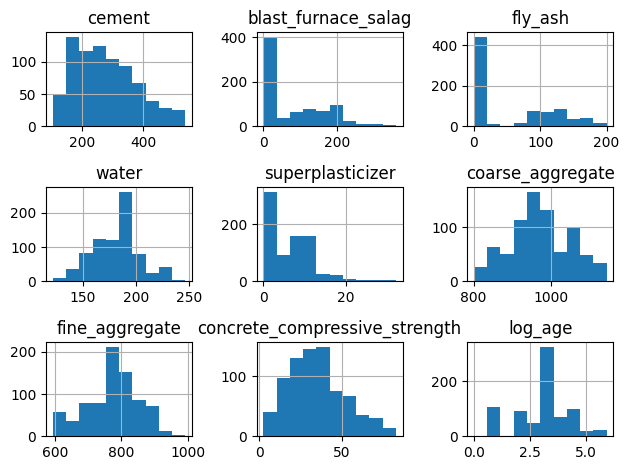

In [ ]:
df_train.hist()
plt.tight_layout()
plt.show()

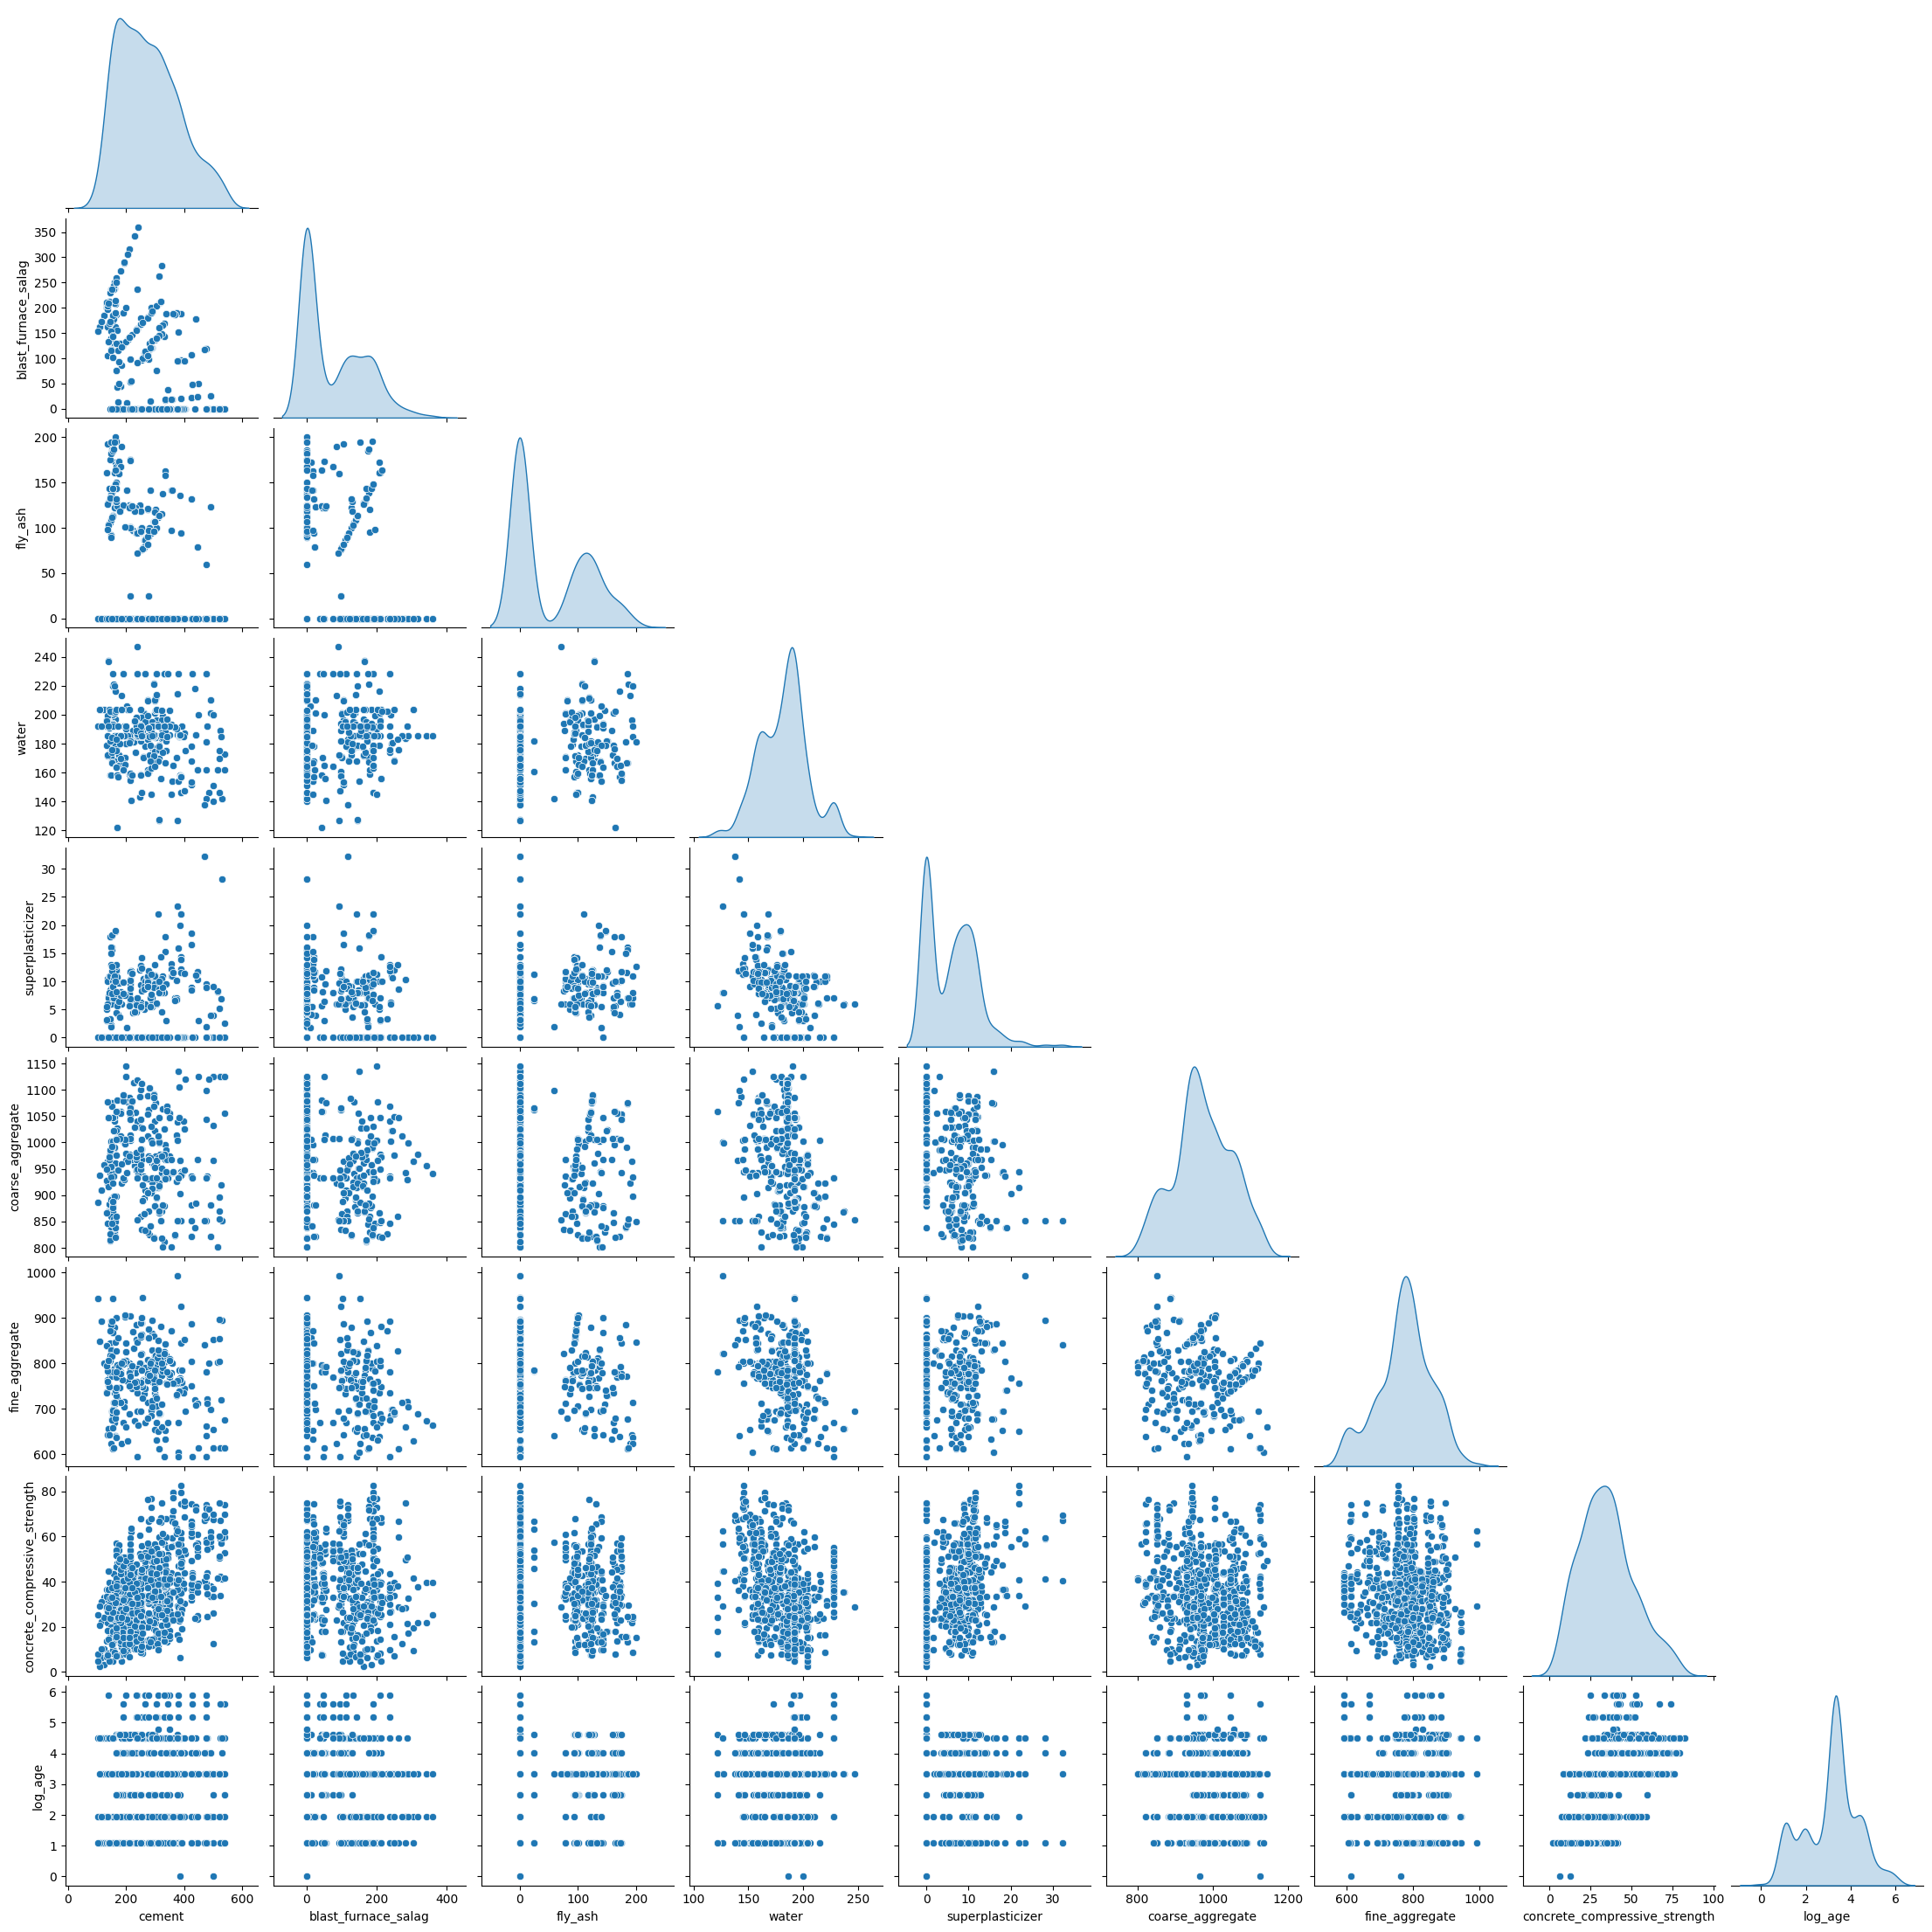

In [ ]:
sns.pairplot(df_train, diag_kind='kde', corner=True)
plt.show()

In [ ]:
df_train.corr().T

,cement,blast_furnace_salag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,concrete_compressive_strength,log_age
cement,1.000000,-0.290142,-0.392565,-0.067864,0.080171,-0.133348,-0.210930,0.477788,-0.005543
blast_furnace_salag,-0.290142,1.000000,-0.303220,0.110267,0.044210,-0.295844,-0.296009,0.139113,-0.012718
fly_ash,-0.392565,-0.303220,1.000000,-0.270643,0.399970,0.015989,0.063410,-0.067576,0.018036
water,-0.067864,0.110267,-0.270643,1.000000,-0.640902,-0.208677,-0.454010,-0.296369,0.137722
superplasticizer,0.080171,0.044210,0.399970,-0.640902,1.000000,-0.237988,0.192984,0.386070,-0.012233
coarse_aggregate,-0.133348,-0.295844,0.015989,-0.208677,-0.237988,1.000000,-0.131032,-0.198970,-0.067842
fine_aggregate,-0.210930,-0.296009,0.063410,-0.454010,0.192984,-0.131032,1.000000,-0.154947,-0.106039
concrete_compressive_strength,0.477788,0.139113,-0.067576,-0.296369,0.386070,-0.198970,-0.154947,1.000000,0.569114
log_age,-0.005543,-0.012718,0.018036,0.137722,-0.012233,-0.067842,-0.106039,0.569114,1.000000


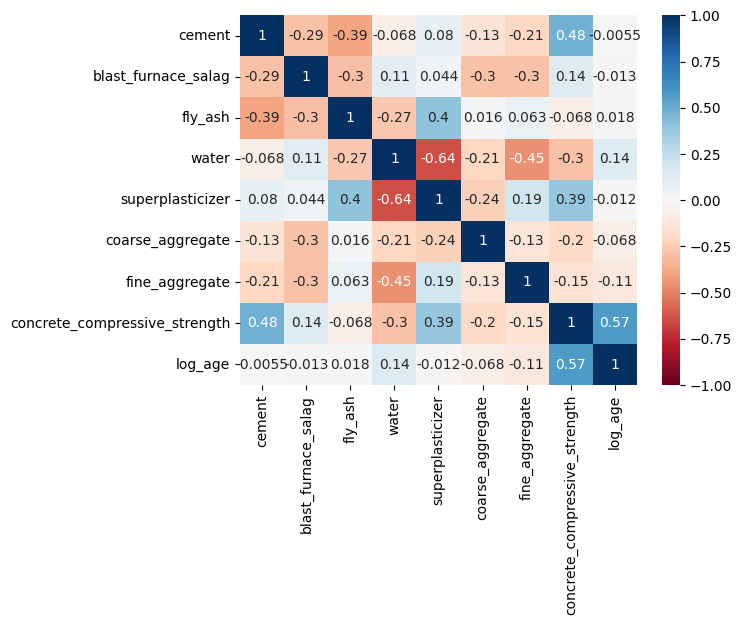

In [ ]:
sns.heatmap(data= df_train.corr(), vmin=-1, vmax=1, cmap="RdBu", annot=True) #Solo funciona con variables numericas
plt.show()

In [ ]:
#Step 4. Machine Learning
X_train = df_train.drop(columns='concrete_compressive_strength')
y_train = df_train['concrete_compressive_strength']

X_val = df_val.drop(columns='concrete_compressive_strength')
y_val = df_val['concrete_compressive_strength']

X_test = df_test.drop(columns='concrete_compressive_strength')
y_test = df_test['concrete_compressive_strength']

In [ ]:
#Pipeline
reg_knn = Pipeline(steps=[
    ('proc',StandardScaler()),
    ('knn', KNeighborsRegressor())
])
reg_knn.fit(X_train, y_train)

Pipeline(steps=[('proc', StandardScaler()), ('knn', KNeighborsRegressor())])

In [ ]:
y_hat = reg_knn.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_hat)):.2f}')
print(f'R2: {r2_score(y_val, y_hat):.2f}')

RMSE: 7.36
R2: 0.81


In [ ]:
reg_knn_cv = GridSearchCV(
    reg_knn,
    param_grid = {
        'knn__n_neighbors':[3,5,7,9,11,13,15,17,19,21],
    },
    cv=5,
)
reg_knn_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('proc', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21]})

In [ ]:
print(f"Mejor numero de vecinos {reg_knn_cv.best_params_}")

Mejor numero de vecinos {'knn__n_neighbors': 3}


In [ ]:
y_hat = reg_knn_cv.predict(X_val)
print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_hat)):.2f}')
print(f'R2: {r2_score(y_val, y_hat):.2f}')

RMSE: 6.67
R2: 0.85


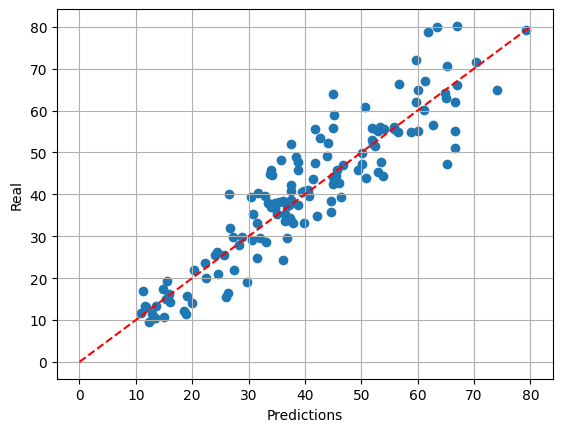

In [ ]:
plt.scatter(x=y_hat, y=y_val)
plt.grid(True)
plt.xlabel("Predictions")
plt.ylabel("Real")
plt.plot([0,80],[0,80],c="r",linestyle='--')
plt.show()

In [ ]:
reg_knn = Pipeline(steps=[
    ('proc',StandardScaler()),
    ('knn', KNeighborsRegressor())
])

reg_tree = Pipeline(steps=[
    ('proc', StandardScaler()),
    ('tree', DecisionTreeRegressor(random_state=2025))
])

reg_rf = Pipeline(steps=[
    ('proc', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=2025))
])

reg_hb = Pipeline(steps=[
    ('proc', StandardScaler()),
    ('hb', HistGradientBoostingRegressor(random_state=2025))
])


In [ ]:
models = [(reg_tree,'Decission Tree','tree'),
          (reg_rf,'Random forest','rf'),
          (reg_hb,'Histogram Boosting','hb'),(reg_knn,'KNeighbors','knn')]

param_grids ={
    'tree':{
        'tree__max_depth':[2,4,5,6,7],
        'tree__min_samples_split':[2,4,6],
    },
    'knn':{
        'knn__n_neighbors':[3,5,7,9,11,13,15,17,19,21]
        },
    'rf':{
        'rf__max_depth':[2,4,5,6,7],
        'rf__min_samples_split':[2,4,6],
        'rf__n_estimators':[50,100,150,200]
    },
    'hb':{
        'hb__max_depth':[2,4,5,6,7]
    }
}

performance = {}

for est, name, sname in models:
  est.fit(X_train, y_train)
  estimator_cv = GridSearchCV(
      est,
      param_grid = param_grids[sname],
      cv = 5
  )

  estimator_cv.fit(X_train, y_train)
  y_hat = estimator_cv.predict(X_val)
  r2 = round(r2_score(y_val,y_hat),2)
  rmse = round(np.sqrt(mean_squared_error(y_val, y_hat)),2)
  mae = round(mean_absolute_error(y_val, y_hat),2)
  params = estimator_cv.best_params_

  performance[name] = {
      'R2 Score':r2,
      'RMSE':rmse,
      'MAE':mae,
      'Best Params':params,
      'estimator':estimator_cv.best_estimator_,
  }

In [ ]:
df_models = pd.DataFrame(performance)
df_models.T

,R2 Score,RMSE,MAE,Best Params,estimator
Decission Tree,0.74,8.7,6.24,"{'tree__max_depth': 7, 'tree__min_samples_spli...","(StandardScaler(), DecisionTreeRegressor(max_d..."
Random forest,0.87,6.07,4.55,"{'rf__max_depth': 7, 'rf__min_samples_split': ...","(StandardScaler(), (DecisionTreeRegressor(max_..."
Histogram Boosting,0.92,4.88,3.35,{'hb__max_depth': 7},"(StandardScaler(), HistGradientBoostingRegress..."
KNeighbors,0.85,6.67,4.96,{'knn__n_neighbors': 3},"(StandardScaler(), KNeighborsRegressor(n_neigh..."


In [ ]:
n_iterations = 50
mse_scores = []
rmse_scores = []
r2_scores = []

for i in range(n_iterations):
  df_rs = resample(df_train)

  # Split data
  X_train_rs = df_rs.drop(columns='concrete_compressive_strength')
  y_train_rs = df_rs['concrete_compressive_strength']

  X_train_rs = X_train_rs.reset_index(drop=True)
  y_train_rs = y_train_rs.reset_index(drop=True)

  # Learning
  reg_hb.fit(X_train_rs, y_train_rs)

  # Prediction
  y_hat = reg_hb.predict(X_test)

  # Metrics
  mse = round(mean_squared_error(y_test, y_hat), 2)
  rmse = np.sqrt(mse)
  r2 = round(r2_score(y_test, y_hat), 2)

  # Add to lists
  mse_scores.append(mse)
  rmse_scores.append(rmse)
  r2_scores.append(r2)

In [ ]:
np.mean(rmse_scores)

np.float64(5.034699220597877)

In [ ]:
print(f'RMSE: {np.mean(rmse_scores)} +/- {1.96*np.std(rmse_scores)}')

RMSE: 5.034699220597877 +/- 0.7835190598573338


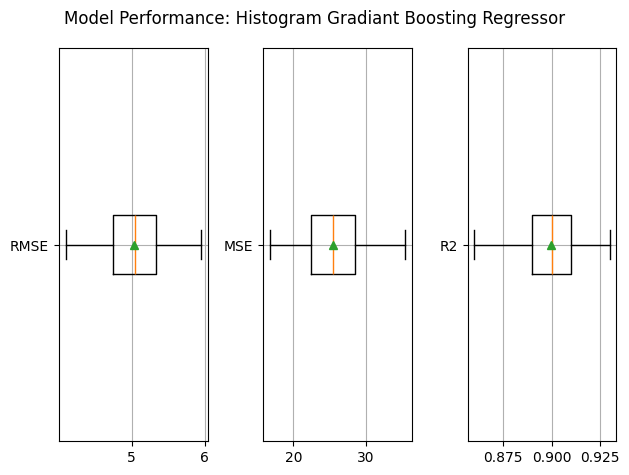

RMSE: 5.0 +/- 0.78
MSE: 2.6e+01 +/- 7.9
R2: 0.9 +/- 0.03


In [ ]:
fig, ax = plt.subplots(1,3)
ax[0].boxplot(x=rmse_scores, vert=False, showmeans=True)
ax[0].grid(True)
ax[0].set_yticks([1],['RMSE'])

ax[1].boxplot(x=mse_scores, vert=False, showmeans=True)
ax[1].grid(True)
ax[1].set_yticks([1],['MSE'])

ax[2].boxplot(x=r2_scores, vert=False, showmeans=True)
ax[2].grid(True)
ax[2].set_yticks([1],['R2'])

plt.suptitle("Model Performance: Histogram Gradiant Boosting Regressor")
plt.tight_layout()
plt.show()

print(f'RMSE: {np.mean(rmse_scores):.2} +/- {1.96 * np.std(rmse_scores):.2}')
print(f'MSE: {np.mean(mse_scores):.2} +/- {1.96 * np.std(mse_scores):.2}')
print(f'R2: {np.mean(r2_scores):.2} +/- {1.96 * np.std(r2_scores):.2}')